By Ahmad Khoshvaght 401422081 
About HDBSCAN

HDBSCAN is a clustering algorithm based on DBSCAN. The difference is that HDBSCAN uses varying epsilon to find the best stable epsilon. So that HDBSCAN is parameterless and has no challenge over finding the best parameter. HDBSCAN converts DBSCAN into a hierachical clustering. 

In continuation I'm going to explain HDBSCAN with python codes. First I'm going to set up a plotting.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as data
%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

Now im going to initialize some data for it

In [ ]:
moons, _ = data.make_moons(n_samples=50, noise=0.05)
blobs, _ = data.make_blobs(n_samples=50, centers=[(-0.75,2.25), (1.0, 2.0)], cluster_std=0.25)
test_data = np.vstack([moons, blobs])
plt.scatter(test_data.T[0], test_data.T[1], color='b', **plot_kwds)

Now importing hdbscan and use it on data

In [ ]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(test_data)

So now that we have clustered the data -- what actually happened? We can break it out into a series of steps

Transform the space according to the density/sparsity.
Build the minimum spanning tree of the distance weighted graph.
Construct a cluster hierarchy of connected components.
Condense the cluster hierarchy based on minimum cluster size.
Extract the stable clusters from the condensed tree.

Transform The Space
Firstly we need to make our model robust against noises. We need an inexpensive way for that. The simplest way is to fing the distance to kth neighbour. If we have distance matrix (Which we will have to compute it anyway) we can use it. alternatively if our metric is supported (and dimension is low) this is the sort of query that kd-trees are good for. Let's formalise this and (following the DBSCAN, LOF, and HDBSCAN literature) call it the core distance defined for parameter k for a point x and denote as corek(x)
. Now we need a way to spread apart points with low density (correspondingly high core distance). The simple way to do this is to define a new distance metric between points which we will call (again following the literature) the mutual reachability distance. We define mutual reachability distance as follows:

dmreach−k(a,b)=max{corek(a),corek(b),d(a,b)}

where d(a,b) is the original metric distance between a and b. Under this metric dense points (with low core distance) remain the same distance from each other but sparser points are pushed away to be at least their core distance away from any other point.

![Alt text](https://nbviewer.org/github/scikit-learn-contrib/hdbscan/blob/master/notebooks/distance4a.svg)

Build the minimum spanning tree
Now we are going to mark out islands of dense data. We will consider data as a weighted graph with each point as vertices and each edge between them is their distance weighted as their mutual reachability distance. There is a threshold on these weighted edges that if their distance is more than that, the edge will be dropped. This is very expesive approach as there are n2 edges. So we use minimum spanning tree to reduce the time consumption. 

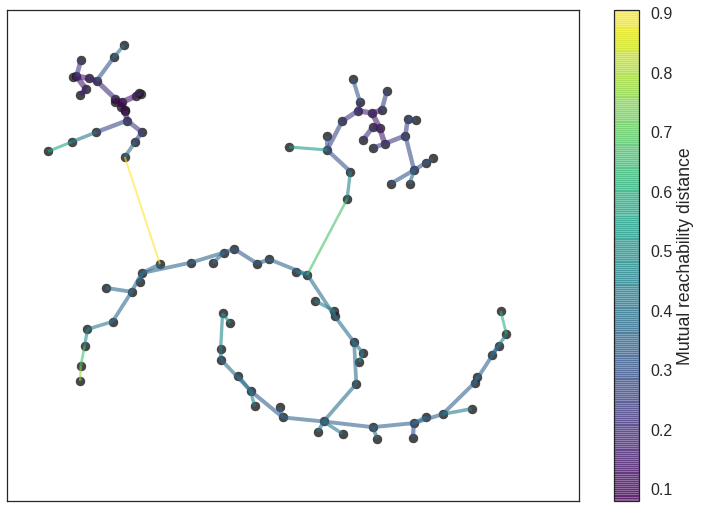

In [ ]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis', 
                                      edge_alpha=0.6, 
                                      node_size=80, 
                                      edge_linewidth=2)

Build the cluster hierarchy
After setting up the minimal spanning tree now we have to convert it into the hierarchy of connected component. This is most easily done by sorting the edges of the tree from lowest to highst and then iterate them through. The tricky part of this is to connect 2 clusters each edge join them together which is done by union-find data structure. The result will be like this:
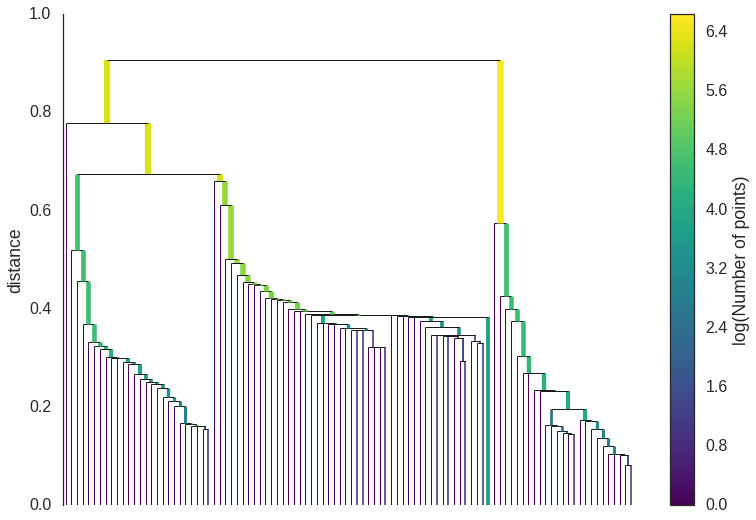

In [ ]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)


Condense the cluster tree
Now we have a hierarchical tree and it is great, but we need a set of flat clusters. We do this by drawing a horizontal line through the above diagram and selecting the clusters that it cuts through. DBSCAN does this by a parameter which we dont have any sense about it. Ideally we want to be able to cut the tree at different places to select our clusters. This is where the next steps of HDBSCAN begin and create the difference from robust single linkage.

We need a notion of minimum cluster size which we take as a parameter to HDBSCAN to walk through the hierarchy and at each split ask if one of the new clusters created by the split has fewer points than the minimum cluster size.  If it is the case that we have fewer points than the minimum cluster size we declare it to be 'points falling out of a cluster' and have the larger cluster retain the cluster identity of the parent, marking down which points 'fell out of the cluster' and at what distance value that happened. If on the other hand the split is into two clusters each at least as large as the minimum cluster size then we consider that a true cluster split and let that split persist in the tree. After walking through the whole hierarchy and doing this we end up with a much smaller tree with a small number of nodes, each of which has data about how the size of the cluster at that node descreases over varying distance.

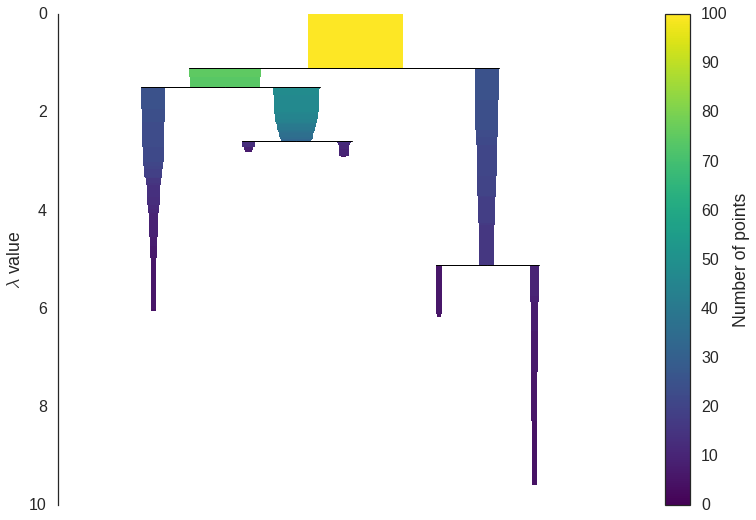

In [ ]:
clusterer.condensed_tree_.plot()

Extract the clusters
Intuitively we want the choose clusters that persist and have a longer lifetime; short lived clusters are ultimately probably merely artifacts of the single linkage approach. To make a flat clustering we will need to add a further requirement that, if you select a cluster, then you cannot select any cluster that is a descendant of it. And in fact that intuitive notion of what should be done is exactly what HDBSCAN does.
First we need a different measure than distance to consider the persistence of clusters; instead we will use λ=1distance
For a given cluster we can then define values λbirth and λdeathto be the lambda value when the cluster split off and became its own cluster, and the lambda value (if any) when the cluster split into smaller clusters respectively. In turn, for a given cluster, for each point p in that cluster we can define the value λpas the lambda value at which that point 'fell out of the cluster' which is a value somewhere between λbirth and λdeath since the point either falls out of the cluster at some point in the cluster's lifetime, or leaves the cluster when the cluster splits into two smaller clusters. Now, for each cluster compute the stability to as

∑p∈cluster(λp−λbirth)
.

Declare all leaf nodes to be selected clusters. Now work up through the tree (the reverse topological sort order). If the sum of the stabilities of the child clusters is greater than the stability of the cluster then we set the cluster stability to be the sum of the child stabilities. If, on the other hand, the cluster's stability is greater than the sum of its children then we declare the cluster to be a selected cluster, and unselect all its descendants. Once we reach the root node we call the current set of selected clusters our flat clsutering and return that.

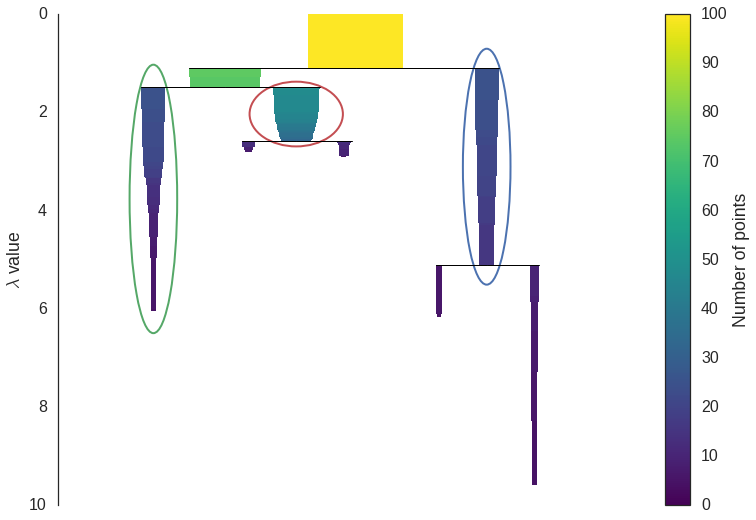

In [ ]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

Now that we have the clusters it is a simple enough matter to turn that into cluster labelling as per the sklearn API. Any point not in a selected cluster is simply a noise point (and assigned the label -1). We can do a little more though: for each cluster we have the λp for each point p in that cluster; If we simply normalize those values (so they range from zero to one) then we have a measure of the strength of cluster membership for each point in the cluster. The hdbscan library returns this as a probabilities_ attribute of the clusterer object. Thus, with labels and membership strengths in hand we can make the standard plot, choosing a color for points based on cluster label, and desaturating that color according the strength of membership (and make unclustered points pure gray).

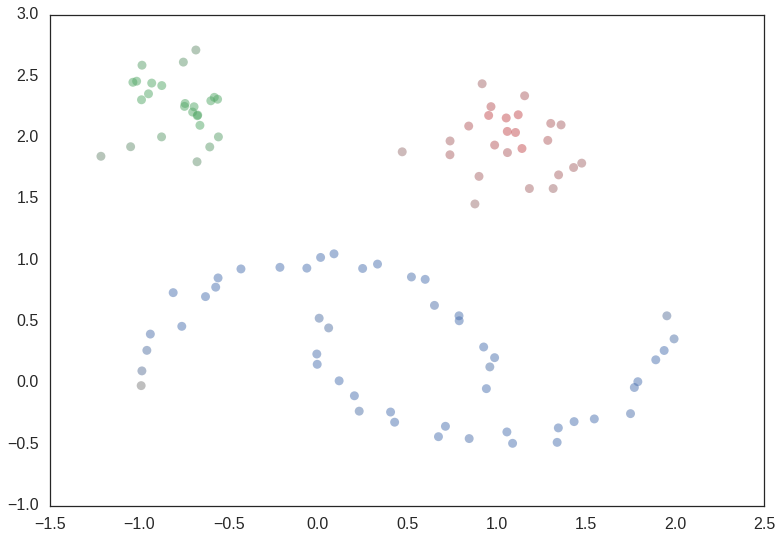

In [ ]:
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat) 
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in 
                  zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(test_data.T[0], test_data.T[1], c=cluster_colors, **plot_kwds)

And that is how HDBSCAN works.